In [1]:

import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is

import csv
import os
import glob
import numpy as np

# filters
import src.saffine.detrending_method as dm
import src.saffine.detrending_coeff as dc

# for testing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

"""
adaptive smoothing filter for time series
order of integration: I(d), of a time series is a summary statistic,
which reports the minimum number of differences required to obtain a covariance
stationary series


"""
def qdp(ts):
    """ quick and dirty signal plotting for testing
    """
    plt.figure()
    #plt.plot(signal[:1000],'k-')
    plt.plot(ts,'k-')
    plt.xlabel('$t$')
    plt.ylabel('$F(t)$')
    plt.show()
    plt.close()

def integrate_ord1(ts):
    """
    first order integration of time series (list or numpy array) ts
    """
    return np.cumsum(ts) - np.mean(ts)

def normalize(ts, scl01 = False):
    ts01 = (ts - np.min(ts)) / (np.max(ts) - np.min(ts))
    ts11 = 2 * ts01 -1
    if scl01:
        return ts01
    else:
        return ts11

In [44]:
def load_signal(file_path):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        signal = [float(i) for i in list(reader)[0]]
        return signal


def make_plot(file_path, window=12):

    filename = os.path.basename(file_path)[:-4]
    print(f'Making plot for {filename}')
    signal = load_signal(file_path)

    signal = integrate_ord1(signal)# fBm


    # parameters
    n = len(signal);# int for doc
    print(n)
    w = int(4 * np.floor(n / 20))
    print(w)
    if w % 2 == 0:
        w = w - 1
    else:
        w = w
    print(f'window: {w}')

    X = np.mat([float(x) for x in signal])

    plt.figure()
    for i in range(1,5):
        noise_ww_1, trend_ww_1 = dm.detrending_method(X, w, i);
        plt.plot(normalize(trend_ww_1).T, label = str(i))#,color[i - 1])

    plt.plot(normalize(X).T,':k', label = 'signal', alpha=0.4)
    plt.legend()
    plt.xlabel('$t$')
    plt.ylabel('$F(t)$')
    plt.savefig(f'../figures/{filename}.png')
    plt.close()

In [35]:

files_ = glob.glob(os.path.join('../data/emotion_data', '*.csv'))




In [45]:
signals = []
for file_ in files_:
    make_plot(file_)

Making plot for fabr005leeu01_01
2852
568
window: 567
Making plot for kerc007voll06_01
2285
456
window: 455
Making plot for heim004will01_01
6601
1320
window: 1319
Making plot for holl008peer01_01
2729
544
window: 543
Making plot for lenn006onze04_01
5050
1008
window: 1007
Making plot for mead002koni01_01
6175
1232
window: 1231
Making plot for schu012arta02_01
7258
1448
window: 1447
Making plot for uil_004lotg01_01
2027
404
window: 403
Making plot for loos005hist03_01
2901
580
window: 579
Making plot for zern001leve01_01
3559
708
window: 707
Making plot for verm025reis01_01
3496
696
window: 695
Making plot for crem001roma09_01
5013
1000
window: 999
Making plot for robb002mann02_01
4815
960
window: 959
Making plot for loos005leve01_01
12221
2444
window: 2443
Making plot for amic003jeug01_01
2433
484
window: 483
Making plot for slee003ekst01_01
4929
984
window: 983
Making plot for moer010onde01_01
2075
412
window: 411
Making plot for ouds001tobi01_01
3888
776
window: 775
Making plot for 

In [96]:
from src.saffine.dfa import *

In [3]:
# test
import csv
with open('../data/emotion_data/kerc007voll09_01.csv', 'r') as f:
    reader = csv.reader(f)
    ts = [float(i) for i in list(reader)[0]]

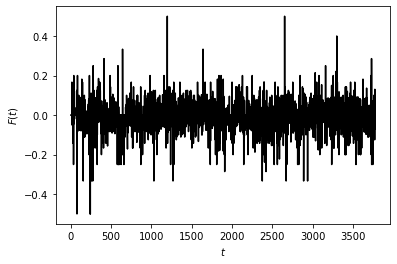

In [5]:
qdp(ts)

In [135]:


baseline = mono_dfa(ts, m = 1)
print("baseline H = {}".format(baseline['H']))
print("test H = {}".format(np.mean(multi_dfa(ts))))

baseline H = 0.55
test H = 0.5942857142857143


In [136]:

scales = [np.power(2,i) for i in range(4,11)]
m = 1
F = []
for scale in scales:
    rms = local_detrend(ts, scale = scale, m = 1)
    F.append(np.sqrt(np.mean(np.power(rms,2))))

# step 2 DFA
C = np.polyfit(np.log2(scales),np.log2(F),1)
H = C[0]
print('H = {}'.format(H))
regline = np.polyval(C,np.log2(scales))

plt.figure()
plt.plot(np.log2(scales),np.log2(F),'ro',np.log2(scales),regline,'k-')
plt.title('$H = {}$'.format(round(H,2)))
plt.xlabel('$log_{2}w$')
plt.ylabel('$log_{2}F(w)$')
plt.savefig('hurst_fit.png')
plt.close()

H = 0.5505054632217781


In [137]:
X = np.cumsum(ts - np.mean(ts))
scale = 200;
m = 1
segments = int(np.floor(len(X)/scale))
index = []
fit = []
rms = []
for v in range(segments):
    idx_start = ((v) * scale)
    idx_stop = (v + 1) * scale
    index.append(range(idx_start,idx_stop))
    X_idx = X[index[v]]
    #print(list(index[v]))
    #print(X[index[v]])
    C = np.polyfit(list(index[v]), X_idx, m)
    fit.append(np.polyval(C, list(index[v])))
    rms.append(np.sqrt(np.mean((np.power(X_idx - fit[v],2)))))
    print(C)
    print(rms)
print('Overall RMS for local fits F = {}'.format(np.sqrt(np.mean(np.power(rms,2)))))

plt.figure()
plt.plot(X,'k')
for i in range(len(index)):
    plt.plot(list(index[i]),fit[i],':r')
    plt.plot(list(index[i]),fit[i] + rms[i] * 1,'-r')
    plt.plot(list(index[i]),fit[i] - rms[i] * 1,'-r')
plt.savefig('local_rms.png')
plt.close()

[-0.00076601 -0.02418861]
[0.2888454580470064]
[-0.00545168  0.86722928]
[0.2888454580470064, 0.15181835648146974]
[-0.00527155  0.05521143]
[0.2888454580470064, 0.15181835648146974, 0.6349168497760216]
[-0.00353425 -0.39522685]
[0.2888454580470064, 0.15181835648146974, 0.6349168497760216, 0.39952048415337804]
[-0.01362371  8.23848553]
[0.2888454580470064, 0.15181835648146974, 0.6349168497760216, 0.39952048415337804, 0.5786120237471009]
[ 1.75469603e-02 -2.19365065e+01]
[0.2888454580470064, 0.15181835648146974, 0.6349168497760216, 0.39952048415337804, 0.5786120237471009, 0.2008229793831915]
Overall RMS for local fits F = 0.41720064686347935


In [138]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

In [142]:
window_size = 250  # Approximately, how many data points might be found in a pattern

mp = stumpy.stump(ts, m=window_size)

In [143]:
motif_idx = np.argsort(mp[:, 0])[0]
nearest_neighbor_idx = mp[motif_idx, 1]

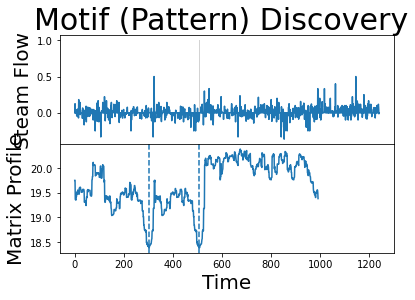

In [144]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(ts)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((motif_idx, 0), m, 1, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 1, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

In [145]:
discord_idx = np.argsort(mp[:, 0])[-1]

print(f"The discord is located at index {discord_idx}")

The discord is located at index 674


In [146]:
nearest_neighbor_distance = mp[discord_idx, 0]

print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

The nearest neighbor subsequence to this discord is 20.386754461677324 units away


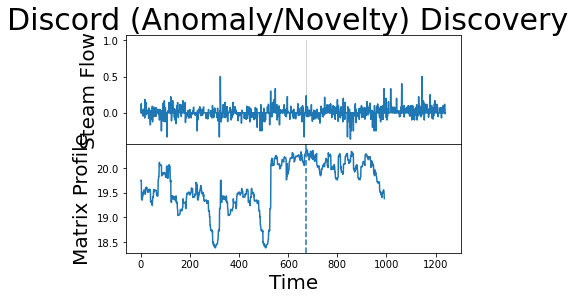

In [147]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='30')

axs[0].plot(ts)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((discord_idx, 0), m, 1, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

In [169]:
m = 100
bsf_radius, bsf_Ts_idx, bsf_subseq_idx = stumpy.ostinato(list(signals.values()), m)
print(f'Found best radius {np.round(bsf_radius, 2)} in time series {bsf_Ts_idx} starting at subsequence index location {bsf_subseq_idx}.')

Found best radius 9.28 in time series 1 starting at subsequence index location 334.


In [170]:
from scipy.special import comb
from itertools import cycle, combinations
from scipy.cluster.hierarchy import linkage, dendrogram

No handles with labels found to put in legend.


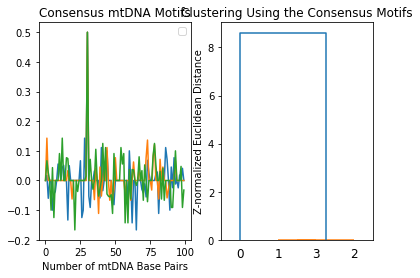

In [173]:
consensus_motifs = {}
best_motif = list(signals.items())[bsf_Ts_idx][1][bsf_subseq_idx : bsf_subseq_idx + m]
for i, (k, v) in enumerate(signals.items()):
    if i == bsf_Ts_idx:
        consensus_motifs[k] = best_motif
    else:
        idx = np.argmin(stumpy.core.mass(best_motif, v))
        consensus_motifs[k] = v[idx : idx + m]

fig, ax = plt.subplots(ncols=2)
# plot the consensus motifs
for animal, motif in consensus_motifs.items():
    ax[0].plot(motif)
ax[0].legend()
# cluster consensus motifs
dp = np.zeros(int(comb(4, 2)))
for i, motif in enumerate(combinations(list(consensus_motifs.values()), 2)):
    dp[i] = stumpy.core.mass(motif[0], motif[1])
Z = linkage(dp, optimal_ordering=True)
dendrogram(Z)

ax[0].set_title('Consensus mtDNA Motifs')
ax[0].set_xlabel('Number of mtDNA Base Pairs')
ax[1].set_title('Clustering Using the Consensus Motifs')
ax[1].set_ylabel('Z-normalized Euclidean Distance')
plt.show()

In [174]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler



In [177]:
from tslearn.utils import to_time_series_dataset
X = to_time_series_dataset(signals)

Euclidean k-means
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
DBA k-means
Init 1


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   20.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   24.4s finished


2929.996 --> 

KeyboardInterrupt: 

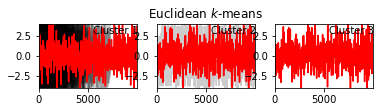

In [185]:
seed = 123
numpy.random.shuffle(X)

X = TimeSeriesScalerMeanVariance().fit_transform(X[:50])

sz = X.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(X)

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          n_jobs=4,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                            n_jobs=4,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X)

for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()